## ================================================================
## BRIAN2 SIMULATION OF A RECURRENT EXCITATORY NEURONAL NETWORK
## ================================================================
This notebook simulates a population of excitatory neurons connected through **AMPA** and **NMDA** synapses using the *Brian2* simulator.  
It includes intrinsic Hodgkin–Huxley-like neuron dynamics, synaptic transmission with short-term depression, and spatially dependent connection delays.  
The simulation outputs **raster plots** and **population firing rates (cIFR)**.

In [ ]:
# ------------------------------------------------
# Import required packages
# ------------------------------------------------

!pip install brian2 -q
from brian2 import *
import numpy as np
from time import time
import matplotlib.pyplot as plt
set_device('cpp_standalone', build_on_run=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


In [ ]:
# ================================================================
# Parameter Setting
# ================================================================
# Define biophysical, synaptic, and network parameters.
# These include Nernst potentials, conductances, time constants,
# network geometry, and noise amplitude.

Ne = 100                            # Number of excitatory neurons
El = -39.2 * mV                     # Nernst potential of leaky ions
EK = -80 * mV                       # Nernst potential of potassium
ENa = 70 * mV                       # Nernst potential of sodium
VT = -30.4*mV                       # alters firing threshold of neurons
E_ampa = 0*mV                       # reverse synaptic potential
tau_ampa = 2*ms                     # synaptic time constant AMPA
E_nmda = 0 * mV                     # Nernst potential of synaptic channels
taud_nmda = 100 * ms                # decay time constant of nmda conductance
taur_nmda = 2 * ms                  # rise time constant of nmda conductance
tau_d = 800 * ms                    # Recovery time constant of synaptic vesicles
Vmax = 25*mm/second                 # Axonal conduction velocity
radius = 160 * um                   # Network spatial radius
fD = 0.0075                         # Synaptic depression strength
g_nmda = 0.0275*nS                  # NMDA synaptic conductance
g_ampa = 0.35*nS                    # AMPA synaptic conductance
sigma = 5.35*mV                     # Membrane potential oscillation amplitude


# ================================================================
# Definition of Cell Intrinsic and Synaptic Equations
# ================================================================
# Hodgkin–Huxley-like intrinsic dynamics with leak, Na+, and K+ currents.
# Includes AMPA and NMDA synaptic currents and a stochastic noise term.

eqs = '''
dV/dt = (noise -gl*(V-El) - g_na*(m**3)*h*(V-ENa) - g_kd*(n**4)*(V-EK) - I_syn)/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
alpha_m = 0.32*(mV**-1)*4*mV/exprel((13*mV-V+VT)/(4*mV))/ms : Hz
beta_m = 0.28*(mV**-1)*5*mV/exprel((V-VT-40*mV)/(5*mV))/ms : Hz
alpha_h = 0.128*exp((17*mV-V+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-V+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*5*mV/exprel((15*mV-V+VT)/(5*mV))/ms : Hz
beta_n = .5*exp((10*mV-V+VT)/(40*mV))/ms : Hz
noise = sigma*(2*gl*Cm)**.5*randn()/sqrt(dt) : amp (constant over dt)
I_syn = I_ampa+I_nmda : amp
I_ampa = g_ampa*(V-E_ampa)*s_ampa : amp
ds_ampa/dt = -s_ampa/tau_ampa : 1
I_nmda = g_nmda*(V-E_nmda)*s_nmda_tot/(1+exp(-0.062*V/mV)/3.57) : amp
s_nmda_tot : 1
x : meter
y : meter
area : meter**2
Cm = (1*uF*cm**-2) * area : farad
g_na = (50*mS*cm**-2) * area : siemens
g_kd = (5*mS*cm**-2) * area : siemens
gl = (0.3*mS*cm**-2) * area : siemens
'''

eqs_synE_model = '''
s_nmda_tot_post = s_nmda * x_d : 1 (summed)
ds_nmda/dt = -s_nmda/(taud_nmda)+x_nmda*(1-s_nmda)/taur_nmda : 1 (clock-driven)
dx_nmda/dt = -x_nmda/(taur_nmda) : 1 (clock-driven)
dx_d/dt = (1-x_d)/tau_d :1 (clock-driven)
'''

eqs_synE_onpre = '''
s_ampa += x_d
x_nmda += 1
x_d *= (1-fD)
'''

# ================================================================
# Network Construction
# ================================================================
# Define neuron group, spatial layout, and synaptic connectivity.

cellsExc = NeuronGroup(Ne, model=eqs, threshold='V>0*mV', refractory=2*ms, method='exponential_euler')
cellsExc.area = 300*um**2
cellsExc.V = El

# Random spatial distribution within circular area
cellsExc.x = np.sqrt(np.random.rand(Ne)) * radius * np.cos(2 * np.pi * np.random.rand(Ne))
cellsExc.y = np.sqrt(np.random.rand(Ne)) * radius * np.sin(2 * np.pi * np.random.rand(Ne))

# Load predefined structural connectivity (source/target pairs)
sources = np.load('source_SF_RND_a2.npy')   # to change accordingly
targets = np.load('target_SF_RND_a2.npy')   # to change accordingly

# Create excitatory synapses
syn_EE = Synapses(cellsExc, cellsExc, model=eqs_synE_model, on_pre=eqs_synE_onpre, method='euler')
syn_EE.connect(i=sources, j=targets)

# Distance-dependent synaptic delays
syn_EE.delay = '(sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2))/Vmax'


# ================================================================
# Simulation Execution and Spike Train saving
# ================================================================
# Run the simulation for a specified duration and record spike times.

spikes = SpikeMonitor(cellsExc)

dur = 65*second
trans = 5*second
run(dur)
start_time = time()
device.build(run=False)
device.run()
sp_t = spikes.t[spikes.t > trans]-trans
sp_i = spikes.i[spikes.t > trans]

np.save('spikesT.npy', sp_t/second)
np.save('spikesI.npy', sp_i)

print(f'Elapsed time: {(time()-start_time):.1f} seconds')


Elapsed time: 65.0 seconds


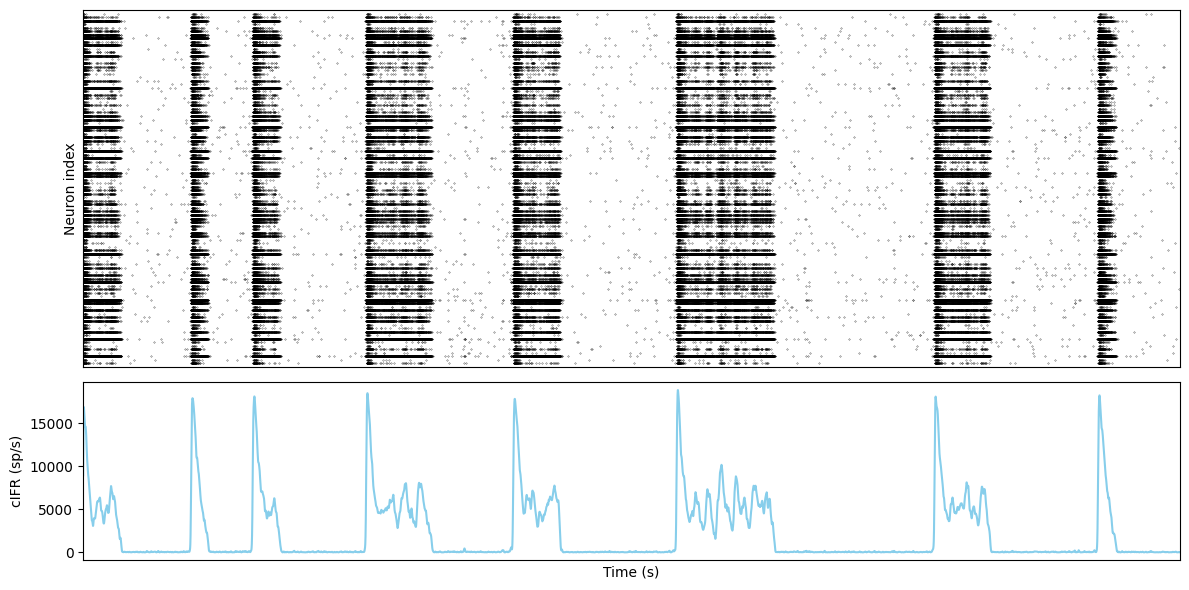

In [ ]:
# ================================================================
# Analysis and Visualization
# ================================================================
# Compute smoothed cumulative instantaneous firing rate (cIFR)
# and generate raster and rate plots.


def gaussian_window(window_size, sigma):
    """Return a normalized Gaussian kernel for smoothing."""
    x = np.linspace(-window_size // 2, window_size // 2, window_size)
    gauss = np.exp(-0.5 * (x / sigma) ** 2)
    return gauss / gauss.sum()

# Parameters
freqSam = 10_000  # Hz
freqSam_sub = 1_000  # Hz
acqTime = int((dur-trans)/second)  # s
n_sam = int(freqSam_sub * acqTime)
smooth_window = 100  # ms
smooth_window = int(smooth_window * freqSam_sub / 1000)

# Cumulative IFR
cum_spikes, sp_count = np.unique((sp_t/second*freqSam_sub).astype(int), return_counts=True)
cum_peak = np.zeros(n_sam)
cum_peak[cum_spikes] = sp_count
cIFR = np.convolve(cum_peak, gaussian_window(smooth_window, smooth_window / 6) * freqSam_sub, mode='same')

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1]})

# Raster Plot
axes[0].scatter(sp_t/second, sp_i, s=0.05, color='k')
axes[0].set_xlim((0, acqTime))
axes[0].set_ylim((-1, 100))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_ylabel('Neuron index')

# cIFR
time_axis = np.arange(n_sam) / freqSam_sub
axes[1].plot(time_axis, cIFR, color='skyblue')
axes[1].set_xlim((0, acqTime))
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('cIFR (sp/s)')

fig.tight_layout()
plt.show()